In [2]:
from PIL import Image
import numpy as np
from palette import *
from util import *
from transfer import *
from tqdm import tqdm
import cv2
import os

## Style Image

In [15]:
def preprocess_style_image(style_img, k=5):
    """
    Preprocess the style image to compute k-means clusters for its color distribution.
    """
    style_img_lab = rgb2lab(style_img)
    style_colors = style_img_lab.getdata()
    bins = {}
    for pixel in style_colors:
        bins[pixel] = bins.get(pixel, 0) + 1
    bins = sample_bins(bins)
    style_means, _ = k_means(bins, k=k, init_mean=True)
    return style_means

def color_transfer_between_images(source_img, source_means, style_means, sample_colors, sample_weight_map, sample_level=16):
    """
    Perform color transfer from the style means to the source image using precomputed clusters.
    """
    source_img_lab = rgb2lab(source_img)
    transferred_img_rgb = img_color_transfer(
        source_img_lab, source_means, style_means,
        sample_weight_map, sample_colors, sample_level
    )
    return transferred_img_rgb

In [16]:
def process_image(source_img_path, style_img_path, output_img_path, k=5):
    """
    Process a source image by applying color transfer from a style image.
    
    Args:
        source_img_path (str): Path to the source image.
        style_img_path (str): Path to the style image.
        output_img_path (str): Path to save the output image.
        k (int): Number of clusters for k-means color extraction.
    
    Returns:
        None
    """
    # Validate input paths
    if not os.path.isfile(source_img_path):
        raise FileNotFoundError(f"Source image '{source_img_path}' not found.")
    if not os.path.isfile(style_img_path):
        raise FileNotFoundError(f"Style image '{style_img_path}' not found.")
    
    # Load source and style images
    source_img = Image.open(source_img_path)
    style_img = Image.open(style_img_path)
    
    # Preprocess the style image
    style_means = preprocess_style_image(style_img, k)
    
    # Preprocess the source image
    source_img_lab = rgb2lab(source_img)
    source_colors = source_img_lab.getdata()
    bins = {}
    for pixel in source_colors:
        bins[pixel] = bins.get(pixel, 0) + 1
    bins = sample_bins(bins)
    source_means, _ = k_means(bins, k=k, init_mean=True)
    
    # Prepare sampling data and compute weight map
    sample_level = 16
    sample_colors = sample_RGB_color(sample_level)
    sample_weight_map = rbf_weights(source_means, sample_colors)
    
    # Apply color transfer
    transferred_img_rgb = color_transfer_between_images(
        source_img, source_means, style_means,
        sample_colors, sample_weight_map, sample_level
    )
    
    # Save the result
    transferred_img = Image.fromarray(np.uint8(transferred_img_rgb))
    transferred_img.save(output_img_path)
    print(f"Output image saved to '{output_img_path}'")


In [27]:
source_img_path = 'output/Lenna.png'
style_img_path = 'output/JohnWIck.jpg'
output_img_path = 'Lenna_JohnWick.png'

process_image(source_img_path, style_img_path, output_img_path, k=5)

using 11 cores CPU
Output image saved to 'Lenna_JohnWick.png'


In [34]:
import matplotlib.pyplot as plt

def plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir):
    """
    Plot the source image, style image (first row), and the output images for varying k values (second row).
    
    Args:
        source_img_path (str): Path to the source image.
        style_img_path (str): Path to the style image.
        k_values (list): List of k values to test.
        output_dir (str): Directory to save the output images and generate plots.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the source and style images
    source_img = Image.open(source_img_path)
    style_img = Image.open(style_img_path)
    
    # Initialize the figure
    n_cols = max(2, len(k_values))  # Minimum of 2 columns for source and style images
    plt.figure(figsize=(4 * n_cols, 8))

    # First row: Source and Style Images
    plt.subplot(2, n_cols, 1)
    plt.imshow(source_img)
    plt.title("Source Image")
    plt.axis("off")

    plt.subplot(2, n_cols, 2)
    plt.imshow(style_img)
    plt.title("Style Image")
    plt.axis("off")

    # Second row: Outputs for varying k
    for i, k in enumerate(k_values):
        output_img_path = os.path.join(output_dir, f"output_k{k}.png")
        process_image(source_img_path, style_img_path, output_img_path, k=k)
        output_img = Image.open(output_img_path)
        
        plt.subplot(2, n_cols, n_cols + i + 1)
        plt.imshow(output_img)
        plt.title(f"Output (k={k})")
        plt.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()


using 11 cores CPU
Output image saved to 'output/results\output_k3.png'
using 11 cores CPU
Output image saved to 'output/results\output_k5.png'
using 11 cores CPU
Output image saved to 'output/results\output_k7.png'
using 11 cores CPU
Output image saved to 'output/results\output_k11.png'


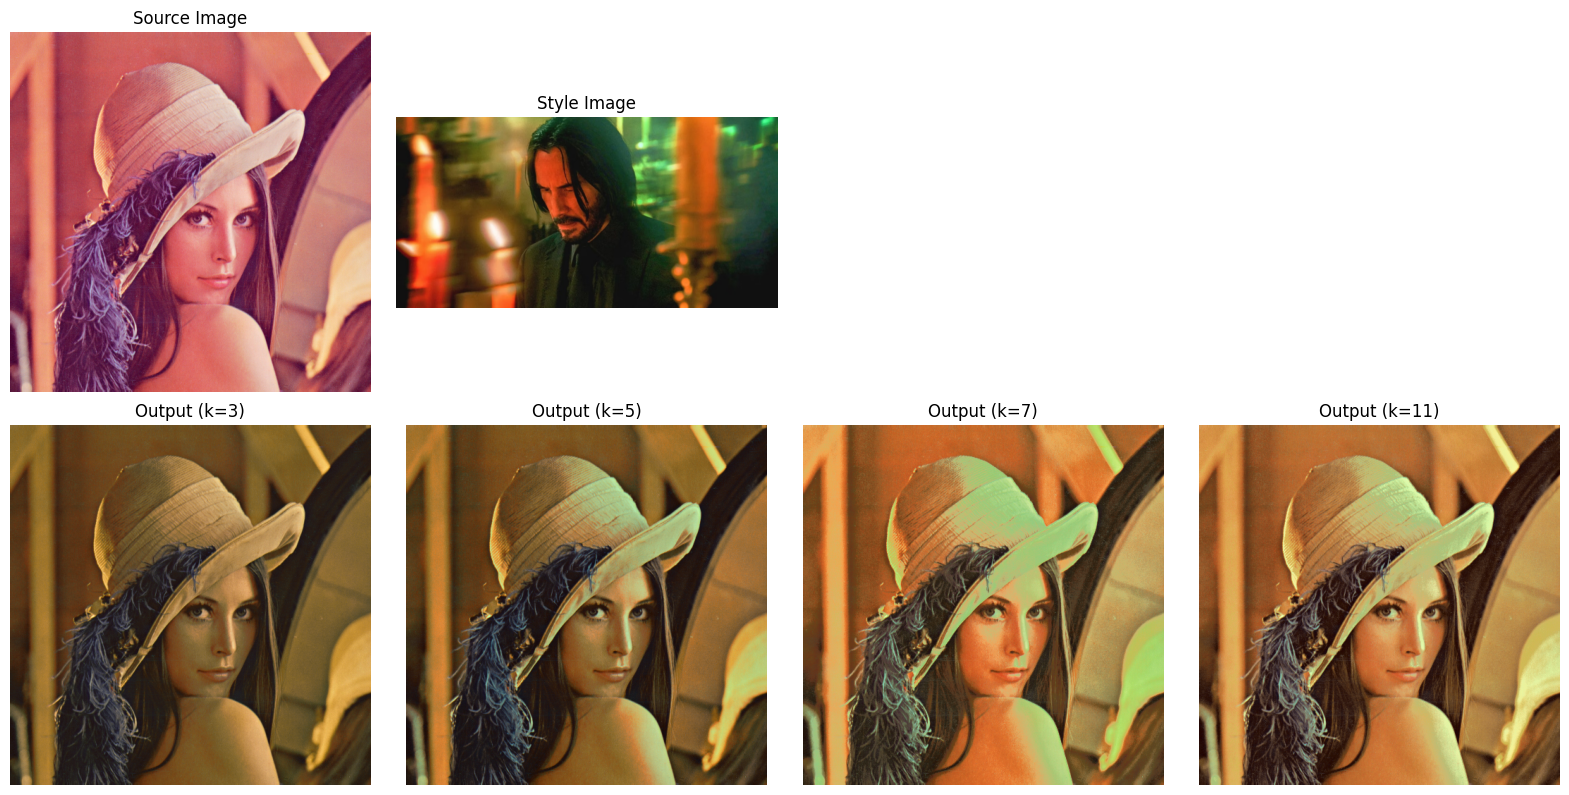

In [35]:
source_img_path = 'output/Lenna.png'
style_img_path = 'output/JohnWIck.jpg'
output_dir = 'output/results'
k_values = [3, 5, 7, 11]

plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir)

using 11 cores CPU
Output image saved to 'output/results\output_k3.png'
using 11 cores CPU
Output image saved to 'output/results\output_k5.png'
using 11 cores CPU
Output image saved to 'output/results\output_k7.png'
using 11 cores CPU
Output image saved to 'output/results\output_k11.png'


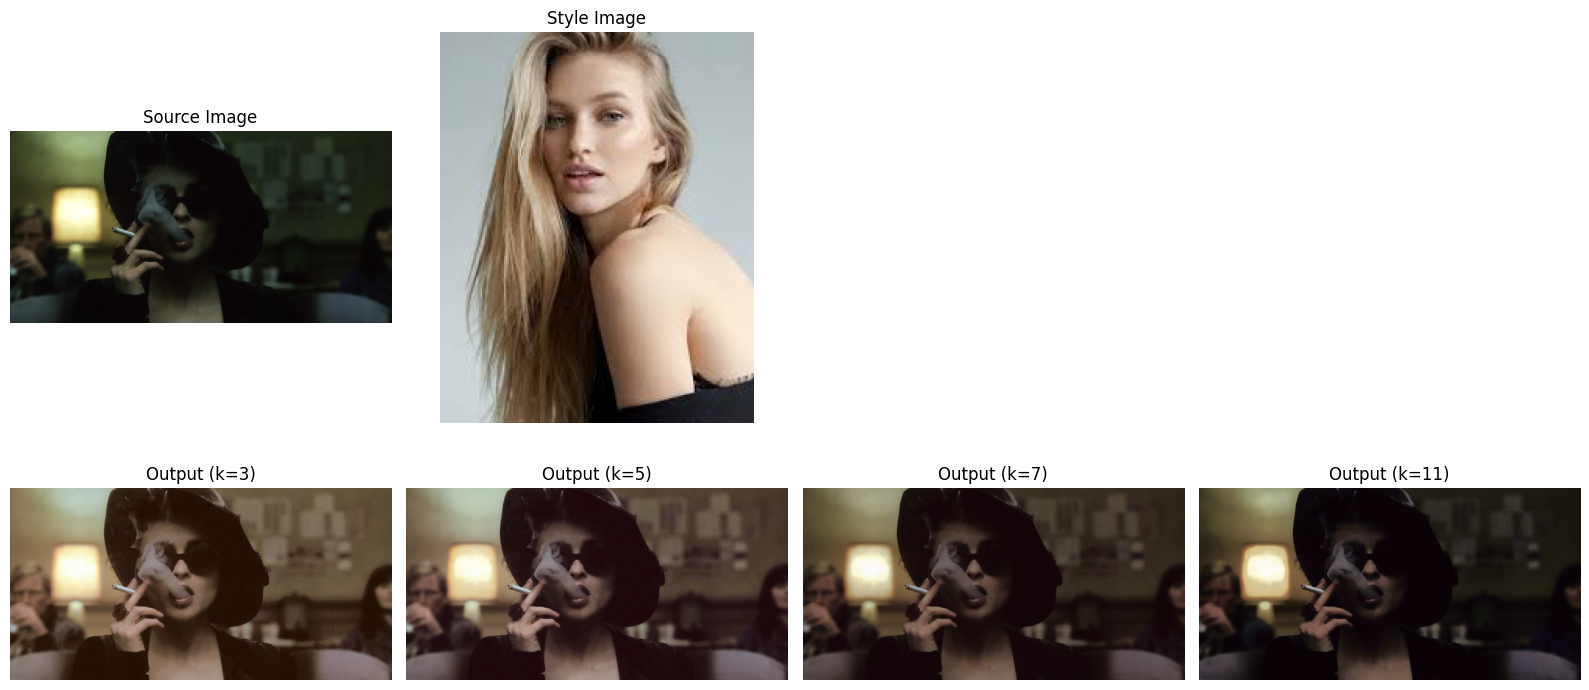

In [36]:
source_img_path = 'input/smokegirl.png'
style_img_path = 'output/Model.jpeg'
output_dir = 'results_smokegirl'
k_values = [3, 5, 7, 11]

plot_images_with_varying_k(source_img_path, style_img_path, k_values, output_dir)

## Style Video

In [13]:
def process_video(source_video_path, style_img_path, output_video_path, k=5):
    """
    Apply color transfer from a style image to each frame of a source video.
    """
    # Validate input paths
    if not os.path.isfile(source_video_path):
        raise FileNotFoundError(f"Source video '{source_video_path}' not found.")
    if not os.path.isfile(style_img_path):
        raise FileNotFoundError(f"Style image '{style_img_path}' not found.")
    
    # Open video and get properties
    cap = cv2.VideoCapture(source_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define codec and create output video writer
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Load style image and preprocess
    style_img = Image.open(style_img_path)
    style_means = preprocess_style_image(style_img, k)

    # Prepare sampling data for source
    sample_level = 16
    sample_colors = sample_RGB_color(sample_level)

    # Process video frames
    with tqdm(total=frame_count, desc="Processing Frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert frame to PIL image
            frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            # Extract source clusters and compute weight map
            source_img_lab = rgb2lab(frame_pil)
            source_colors = source_img_lab.getdata()
            bins = {}
            for pixel in source_colors:
                bins[pixel] = bins.get(pixel, 0) + 1
            bins = sample_bins(bins)
            source_means, _ = k_means(bins, k=k, init_mean=True)
            sample_weight_map = rbf_weights(source_means, sample_colors)

            # Apply color transfer
            transferred_frame_rgb = img_color_transfer(
                source_img_lab, source_means, style_means,
                sample_weight_map, sample_colors, sample_level
            )
            
            # Convert back to OpenCV format and write to output
            transferred_frame_bgr = cv2.cvtColor(np.array(transferred_frame_rgb), cv2.COLOR_RGB2BGR)
            out.write(transferred_frame_bgr)
            
            pbar.update(1)

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [14]:
source_video_path = 'Venice.mp4'
style_img_path = 'output/JohnWIck.jpg'
output_video_path = 'output/processed_v_johnwick.avi'

process_video(source_video_path, style_img_path, output_video_path)

Processing Frames:   0%|          | 0/151 [00:00<?, ?it/s]

using 11 cores CPU


Processing Frames:   1%|          | 1/151 [00:08<21:02,  8.42s/it]

using 11 cores CPU


Processing Frames:   1%|▏         | 2/151 [00:16<20:24,  8.22s/it]

using 11 cores CPU


Processing Frames:   1%|▏         | 2/151 [00:22<28:17, 11.39s/it]


KeyboardInterrupt: 

## Harmonization

In [1]:
import math
import numpy as np
import cv2 

type_m = ['i type', 'L type', 'mirror-L type', 'V type', 'I type', 'Y type', 'X type', 'T type'] 
type_name = ['i-type', 'L-type', 'mirror-L', 'V-type', 'I-type', 'Y-type', 'X-type', 'T-type'] 
Tm = np.array([[0,9,0,9],[0,39.6,90,9],[90,39.6,0,9],[0,46.8,0,46.8],[0,9,180,9],[0,9,180,46.8],[0,46.8,180,46.8],[0,90,0,90]])
phi = 0.38197

def shift_hue(img, deg):
    #deg = 180 * deg / 360
    #deg = (deg + 180) % 180
    deg = fit_hue(deg)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            img[i][j][0] = (img[i][j][0] + deg) % 180
def G(sigma, x):
    return math.exp(-1 * x**2 / (2 * sigma**2))
def arc_dist(a1, a2):
    return min((a1 - a2) % 360, (a2 - a1) % 360)
def arc_dist_180(a1, a2):
    return real_hue(min((a1 - a2) % 180, (a2 - a1) % 180))
def dtr(t):
    return t * math.pi / 180
def rth(t): ## radians to hue 
    return t * 90 / math.pi
def fit_hue(h):
    return 180 * (h % 360) / 360 ## 0 < h < 180
def real_hue(h):
    return 360 * (h % 180) / 180 ## 0 < h < 360
def hue_border_dist(m, alpha, hue): ## 0 < alpha, hue < 360
    ret1 = 180
    delta = abs((hue - (Tm[m][0] + alpha) + 180) % 360 - 180) # 0 < d < 180
    if delta < Tm[m][1]: 
        return 0
    else:
        ret1 = delta - Tm[m][1]
    ret2 = 180
    delta = abs((hue - (Tm[m][2] + alpha) + 180) % 360 - 180) # 0 < d < 180
    if delta < Tm[m][3]: 
        return 0
    else:
        ret2 = delta - Tm[m][3]
    return dtr(ret1) if ret1 < ret2 else dtr(ret2) ## ret > 0 (radians)
def direction(m, hue, C1, C2): ## 0 < alpha, hue < 180
    ret1 = 90
    delta = abs((hue - C1 + 90) % 180 - 90) # 0 < d < 180
    if delta < Tm[m][1]: 
        return 1
    else:
        ret1 = delta - Tm[m][1]
    ret2 = 180
    delta = abs((hue - C2 + 90) % 180 - 90) # 0 < d < 180
    if delta < Tm[m][3]: 
        return 2
    else:
        ret2 = delta - Tm[m][3]
    return 1 if ret1 < ret2 else 2 

def determine_F(img, m, alpha, weight):
    f = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            f += hue_border_dist(m, alpha, real_hue(img[i][j][0])) \
                * img[i][j][1] * weight[i][j]
    return f ## f > 0
def angle_mid(a0, a1):
    r = 0.5
    ret = 0
    if (a0 - a1) % 360 < (a1 - a0) % 360:
        ret = (a0 - ((a0 - a1) % 360) * r) % 360
    else:
        ret = (a0 + ((a1 - a0) % 360) * r) % 360
    return ret
def brent(img, m, w):
    ##### brent's method #####
    a0, a1, a2 = 0, 120, 240
    #f0, f1, f2
    f0 = determine_F(img, m, a0, w)
    f1 = determine_F(img, m, a1, w)
    f2 = determine_F(img, m, a2, w)
    if f0 < f1 and f0 < f2:
        a0, a1, a2 = a2, a0, a1
        f0, f1, f2 = f2, f0, f1
    elif f2 < f1 and f2 < f0:
        a0, a1, a2 = a1, a2, a0 
        f0, f1, f2 = f1, f2, f0 
    while (arc_dist(a2,a0) > 0.5):
        ##if abs((a1 - a0) % 360) > abs((a2 - a1) % 360):
        if arc_dist(a1, a0) > arc_dist(a2, a1):
            x = angle_mid(a0,a1)
            fx = determine_F(img, m, x, w)
            #print(a0,'\t',x,'\t',a1,'\t',a2)
            if fx < f1:
                a2, f2 = a1, f1
                a1, f1 = x, fx
            else:
                a0, f0 = x, fx
        else:
            x = angle_mid(a2,a1)
            fx = determine_F(img, m, x, w)
            #print(a0,'\t',a1,'\t',x,'\t',a2)
            if fx < f1:
                a0, f0 = a1, f1
                a1, f1 = x, fx
            else:
                a2, f2 = x, fx
    return f1, m, a1
    ##### brent's method #####
def harm_shift(H_img, m, alpha, s_w):
    w1 = 2 * dtr(Tm[m][1])
    w2 = 2 * dtr(Tm[m][3])
    ##print(w1,w2)
    sigma1 = w1 * s_w
    sigma2 = w2 * s_w
    C1 = fit_hue(Tm[m][0] + alpha)
    C2 = fit_hue(Tm[m][2] + alpha)
    for i in range(0,H_img.shape[0]):
        for j in range(0,H_img.shape[1]):
            #print(H_img[i][j])
            #if arc_dist_180(H_img[i][j][0], C1) < arc_dist_180(H_img[i][j][0], C2) :
            #print(m, H_img[i][j][0], C1, C2)
            if direction(m, H_img[i][j][0], C1, C2) == 1:
                if (C1 - H_img[i][j][0]) % 180 < (H_img[i][j][0] - C1) % 180 :
                    H_img[i][j][0] = \
                        (C1 - rth(w1)/2 * (1-G(sigma1, dtr(arc_dist_180(H_img[i][j][0],C1))))) % 180
                else:
                    H_img[i][j][0] = \
                        (C1 + rth(w1)/2 * (1-G(sigma1, dtr(arc_dist_180(H_img[i][j][0],C1))))) % 180
            else:
                if (C2 - H_img[i][j][0]) % 180 < (H_img[i][j][0] - C2) % 180 :
                    H_img[i][j][0] = \
                        (C2 - rth(w2)/2 * (1-G(sigma2, dtr(arc_dist_180(H_img[i][j][0],C2))))) % 180
                else:
                    H_img[i][j][0] = \
                        (C2 + rth(w2)/2 * (1-G(sigma2, dtr(arc_dist_180(H_img[i][j][0],C2))))) % 180
            #print(H_img[i][j])
    return H_img

def auto_palette(palette_rgb, weight): # K x 3 numpy array
    k = palette_rgb.shape[0]
    palette_rgb = palette_rgb.reshape(1,k,3)
    weight = weight.reshape(1,k)
    palette_hsv = cv2.cvtColor(palette_rgb.astype(np.ubyte), cv2.COLOR_RGB2HSV)

    Result = np.zeros((8,3))
    for m in range(0,8):
        Result[m] = brent(palette_hsv,m,weight)
        print('F =',Result[m][0],'\talpha =',Result[m][2])
    
    Result = Result[np.argsort(Result[:,0])]
    print(Result)
    m = 0
    print(m)
    M, Alpha = int(Result[m][1]), Result[m][2]
    sigma_w_ratio = 0.5
    palette_hsv = harm_shift(palette_hsv, M, Alpha, sigma_w_ratio)
    palette_rgb = cv2.cvtColor(palette_hsv,cv2.COLOR_HSV2RGB)##back to RGB
    return palette_rgb[0]


In [42]:
def harmonize_image(input_image_path, output_image_path):
    """
    Harmonizes an image based on color harmony principles.
    
    Args:
        input_image_path (str): Path to the input image file.
        output_image_path (str): Path where the harmonized image will be saved.
    """
    # Load the input image
    Img = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if Img is None:
        raise FileNotFoundError(f"Could not read image: {input_image_path}")

    # Convert image to HSV color space
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV)

    # Create a weight matrix (uniform weights for simplicity)
    weight = np.ones((Img.shape[0], Img.shape[1]))

    # Perform Brent's method for all harmony types
    Result = np.zeros((8, 3))  # 8 harmony types
    for m in range(8):
        Result[m] = brent(Img, m, weight)
        print(f"Type {type_m[m]}: F = {Result[m][0]}, Alpha = {Result[m][2]}")

    # Sort by minimum F (select the best harmony type)
    Result = Result[np.argsort(Result[:, 0])]
    best_harmony = Result[0]  # Choose the best harmony
    M, Alpha = int(best_harmony[1]), best_harmony[2]
    print(f"Selected Harmony: {type_m[M]}, Alpha = {Alpha}")

    # Apply harmonic shift
    sigma_w_ratio = 0.5
    harm_shift(Img, M, Alpha, sigma_w_ratio)

    # Convert back to BGR and save
    Img_harmonized = cv2.cvtColor(Img, cv2.COLOR_HSV2BGR)
    cv2.imwrite(output_image_path, Img_harmonized)
    print(f"Harmonized image saved to: {output_image_path}")


In [43]:
input_image_path = 'input/Model.jpeg'
output_image_path = 'output_harmonized_image.jpg'

harmonize_image(input_image_path, output_image_path)


Type i type: F = 897458.7662606682, Alpha = 26.953125
Type L type: F = 303996.4424172527, Alpha = 57.65625
Type mirror-L type: F = 321240.476723005, Alpha = 264.375
Type V type: F = 540343.2336221467, Alpha = 64.921875
Type I type: F = 134615.89748489886, Alpha = 24.84375
Type Y type: F = 58875.52839698707, Alpha = 198.984375
Type X type: F = 12929.26689008319, Alpha = 26.71875
Type T type: F = 105290.48732983031, Alpha = 100.078125
Selected Harmony: X type, Alpha = 26.71875
Harmonized image saved to: output_harmonized_image.jpg


In [46]:
def harmonize_image(input_image_path, output_image_path):
    """
    Harmonizes an image based on color harmony principles and plots all types of harmonized images.
    
    Args:
        input_image_path (str): Path to the input image file.
        output_image_path (str): Path where the harmonized image will be saved.
    """
    # Load the input image
    Img = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if Img is None:
        raise FileNotFoundError(f"Could not read image: {input_image_path}")

    # Convert image to HSV color space
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV)

    # Create a weight matrix (uniform weights for simplicity)
    weight = np.ones((Img.shape[0], Img.shape[1]))

    # Perform Brent's method for all harmony types
    Result = np.zeros((8, 3))  # 8 harmony types
    harmonized_images = []  # List to hold harmonized images

    for m in range(8):
        print(f"Processing {type_m[m]}...")
        # Apply Brent's method to find optimal alpha for each type
        Result[m] = brent(Img, m, weight)
        print(f"{type_m[m]}: F = {Result[m][0]}, Alpha = {Result[m][2]}")

        # Sort by minimum F (select the best harmony type)
        Result = Result[np.argsort(Result[:, 0])]
        M, Alpha = int(Result[m][1]), Result[m][2]

        # Apply harmonic shift for each type
        tmp_img = Img.copy()
        harm_shift(tmp_img, M, Alpha, 0.5)  # Apply harmonic shift

        # Convert the harmonized image back to BGR
        harmonized_bgr = cv2.cvtColor(tmp_img, cv2.COLOR_HSV2BGR)
        harmonized_images.append(harmonized_bgr)  # Store the result in BGR format

    # Plot original image and all harmonized images in a single plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # Plot original image (top-left)
    axes[0, 0].imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Plot each harmonized image in remaining slots
    for i in range(8):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axes[row, col].imshow(cv2.cvtColor(harmonized_images[i], cv2.COLOR_BGR2RGB))  # Convert to RGB for plotting
        axes[row, col].set_title(f'{type_name[i]}')
        axes[row, col].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Save the harmonized image with the best harmony (you can choose the one with the minimum F)
    best_harmony = Result[0]  # Best harmony based on F value
    M, Alpha = int(best_harmony[1]), best_harmony[2]
    harm_shift(Img, M, Alpha, 0.5)
    Img_harmonized = cv2.cvtColor(Img, cv2.COLOR_HSV2BGR)
    cv2.imwrite(output_image_path, Img_harmonized)
    print(f"Harmonized image saved to: {output_image_path}")

Processing i type...
i type: F = 897458.7662606682, Alpha = 26.953125
Processing L type...
L type: F = 303996.4424172527, Alpha = 57.65625
Processing mirror-L type...
mirror-L type: F = 321240.476723005, Alpha = 264.375
Processing V type...
V type: F = 540343.2336221467, Alpha = 64.921875
Processing I type...
I type: F = 134615.89748489886, Alpha = 24.84375
Processing Y type...
Y type: F = 58875.52839698707, Alpha = 198.984375
Processing X type...
X type: F = 12929.26689008319, Alpha = 26.71875
Processing T type...
T type: F = 105290.48732983031, Alpha = 100.078125


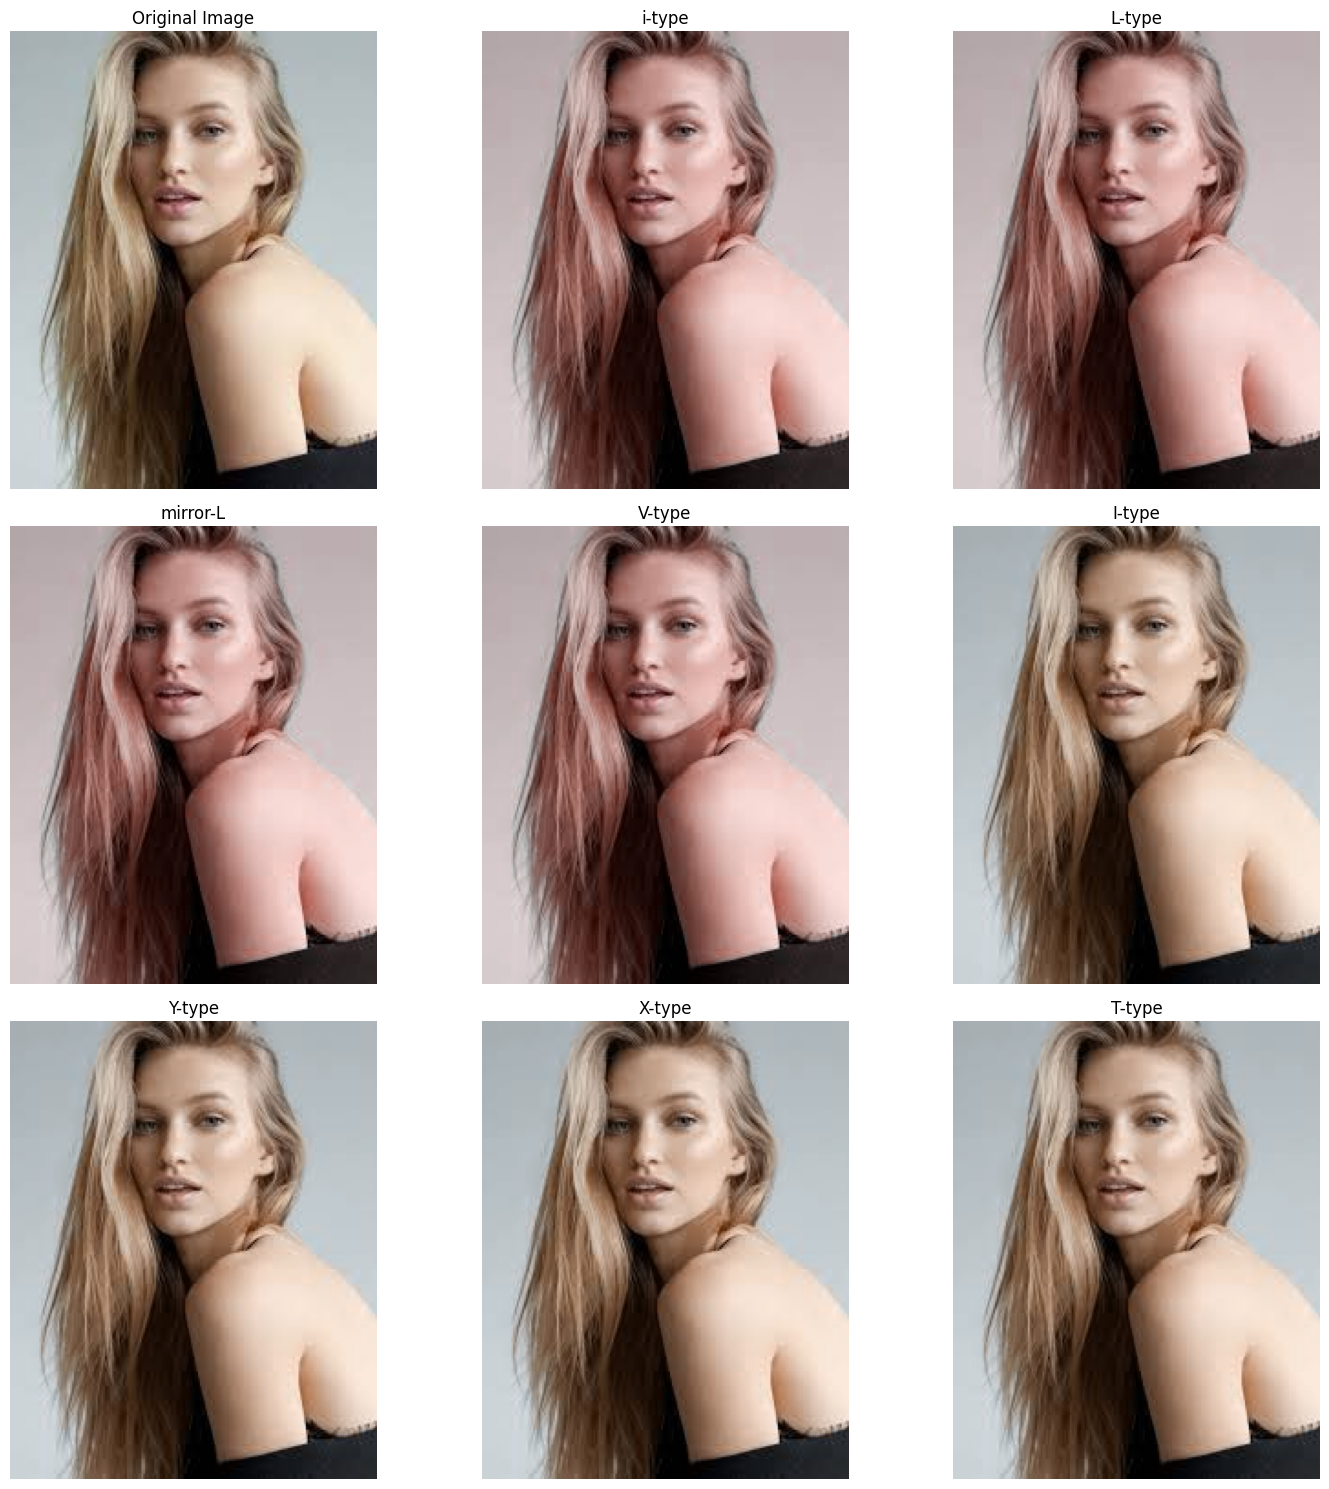

Harmonized image saved to: output_harmonized_image2.jpg


In [47]:
input_image_path = 'input/Model.jpeg'
output_image_path = 'output_harmonized_image2.jpg'

harmonize_image(input_image_path, output_image_path)


## Harmonizing Video

In [2]:
from tqdm import tqdm  # Import tqdm for progress bar

def harmonize_video(input_video_path, output_video_path, harmony_type, harmonization_function):
    """
    Applies color harmonization on each frame of the video based on the specified harmony type.
    
    Args:
        input_video_path (str): Path to the input video file.
        output_video_path (str): Path where the processed video will be saved.
        harmony_type (int): The harmony type to apply (from 0 to 7 corresponding to the types).
        harmonization_function (function): The function to apply the harmonic shift.
    """
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video: {input_video_path}")

    # Get the video properties (frame width, height, and FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video

    # Define the codec and create VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Process each frame of the video with progress bar
    with tqdm(total=total_frames, desc="Processing video", unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # If there are no frames left, break the loop

            # Convert the frame to HSV color space
            frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Create a weight matrix (uniform weights for simplicity)
            weight = np.ones((frame_hsv.shape[0], frame_hsv.shape[1]))

            # Apply Brent's method to find optimal alpha for the specified harmony type
            result = brent(frame_hsv, harmony_type, weight)  # Assuming `brent` is the method that returns F, M, Alpha
            M, Alpha = int(result[1]), result[2]

            # Apply harmonic shift to the frame
            harmonized_frame_hsv = frame_hsv.copy()
            harmonization_function(harmonized_frame_hsv, M, Alpha, 0.5)

            # Convert the harmonized frame back to BGR
            harmonized_frame_bgr = cv2.cvtColor(harmonized_frame_hsv, cv2.COLOR_HSV2BGR)

            # Write the processed frame to the output video
            out.write(harmonized_frame_bgr)

            # Update the progress bar
            pbar.update(1)
            print(1)

    # Release the video capture and writer objects
    cap.release()
    out.release()
    print(f"Harmonized video saved to: {output_video_path}")

In [10]:
input_video_path = 'goat.mp4'
output_video_path = 'goat_Harmonized_type8.mp4'
harmony_type = 7 # T type (7) and L (1) type done.
harmonization_function = harm_shift
harmonize_video(input_video_path, output_video_path, harmony_type, harmonization_function)

Processing video:   0%|          | 0/162 [00:00<?, ?frame/s]

Processing video:   1%|          | 1/162 [00:53<2:23:27, 53.46s/frame]

1


Processing video:   1%|          | 2/162 [01:46<2:21:07, 52.92s/frame]

1


Processing video:   2%|▏         | 3/162 [02:38<2:19:31, 52.65s/frame]

1


Processing video:   2%|▏         | 4/162 [03:31<2:18:54, 52.75s/frame]

1


Processing video:   3%|▎         | 5/162 [04:23<2:17:37, 52.59s/frame]

1


Processing video:   4%|▎         | 6/162 [05:15<2:16:08, 52.37s/frame]

1


Processing video:   4%|▍         | 7/162 [06:07<2:14:54, 52.22s/frame]

1


Processing video:   5%|▍         | 8/162 [06:59<2:14:09, 52.27s/frame]

1


Processing video:   6%|▌         | 9/162 [07:49<2:11:30, 51.57s/frame]

1


Processing video:   6%|▌         | 10/162 [09:17<2:38:38, 62.62s/frame]

1


Processing video:   7%|▋         | 11/162 [11:00<3:08:36, 74.94s/frame]

1


Processing video:   7%|▋         | 12/162 [12:47<3:32:00, 84.80s/frame]

1


Processing video:   8%|▊         | 13/162 [14:44<3:54:42, 94.51s/frame]

1


Processing video:   9%|▊         | 14/162 [16:30<4:01:37, 97.96s/frame]

1


Processing video:   9%|▉         | 15/162 [18:28<4:15:20, 104.22s/frame]

1


Processing video:  10%|▉         | 16/162 [20:19<4:18:35, 106.27s/frame]

1


Processing video:  10%|█         | 17/162 [22:18<4:26:02, 110.09s/frame]

1


Processing video:  11%|█         | 18/162 [24:21<4:32:52, 113.70s/frame]

1


Processing video:  12%|█▏        | 19/162 [26:11<4:28:49, 112.79s/frame]

1


Processing video:  12%|█▏        | 20/162 [28:06<4:28:29, 113.45s/frame]

1


Processing video:  13%|█▎        | 21/162 [29:59<4:25:59, 113.19s/frame]

1


Processing video:  14%|█▎        | 22/162 [31:59<4:28:49, 115.21s/frame]

1


Processing video:  14%|█▍        | 23/162 [33:50<4:23:56, 113.93s/frame]

1


Processing video:  15%|█▍        | 24/162 [35:49<4:25:29, 115.43s/frame]

1


Processing video:  15%|█▌        | 25/162 [37:33<4:15:49, 112.04s/frame]

1


Processing video:  16%|█▌        | 26/162 [38:27<3:34:43, 94.73s/frame] 

1


Processing video:  17%|█▋        | 27/162 [39:17<3:02:46, 81.23s/frame]

1


Processing video:  17%|█▋        | 28/162 [40:06<2:39:59, 71.64s/frame]

1


Processing video:  18%|█▊        | 29/162 [40:53<2:22:08, 64.12s/frame]

1


Processing video:  19%|█▊        | 30/162 [41:39<2:09:31, 58.87s/frame]

1


Processing video:  19%|█▉        | 31/162 [42:26<2:00:32, 55.21s/frame]

1


Processing video:  20%|█▉        | 32/162 [43:13<1:54:21, 52.78s/frame]

1


Processing video:  20%|██        | 33/162 [44:06<1:53:17, 52.70s/frame]

1


Processing video:  21%|██        | 34/162 [44:53<1:49:01, 51.11s/frame]

1


Processing video:  22%|██▏       | 35/162 [45:43<1:47:22, 50.73s/frame]

1


Processing video:  22%|██▏       | 36/162 [46:35<1:47:46, 51.32s/frame]

1


Processing video:  23%|██▎       | 37/162 [47:25<1:46:06, 50.93s/frame]

1


Processing video:  23%|██▎       | 38/162 [48:18<1:45:58, 51.28s/frame]

1


Processing video:  24%|██▍       | 39/162 [49:09<1:45:25, 51.42s/frame]

1


Processing video:  25%|██▍       | 40/162 [50:03<1:45:38, 51.96s/frame]

1


Processing video:  25%|██▌       | 41/162 [50:50<1:41:48, 50.48s/frame]

1


Processing video:  26%|██▌       | 42/162 [51:40<1:40:47, 50.39s/frame]

1


Processing video:  27%|██▋       | 43/162 [52:31<1:40:14, 50.54s/frame]

1


Processing video:  27%|██▋       | 44/162 [53:21<1:39:06, 50.39s/frame]

1


Processing video:  28%|██▊       | 45/162 [54:10<1:37:23, 49.95s/frame]

1


Processing video:  28%|██▊       | 46/162 [54:59<1:35:57, 49.64s/frame]

1


Processing video:  29%|██▉       | 47/162 [55:52<1:37:36, 50.92s/frame]

1


Processing video:  30%|██▉       | 48/162 [56:43<1:36:15, 50.66s/frame]

1


Processing video:  30%|███       | 49/162 [57:33<1:35:05, 50.50s/frame]

1


Processing video:  31%|███       | 50/162 [58:20<1:32:42, 49.66s/frame]

1


Processing video:  31%|███▏      | 51/162 [59:09<1:31:06, 49.24s/frame]

1


Processing video:  32%|███▏      | 52/162 [59:59<1:31:04, 49.68s/frame]

1


Processing video:  33%|███▎      | 53/162 [1:00:51<1:31:15, 50.24s/frame]

1


Processing video:  33%|███▎      | 54/162 [1:01:42<1:30:44, 50.41s/frame]

1


Processing video:  34%|███▍      | 55/162 [1:02:31<1:29:05, 49.96s/frame]

1


Processing video:  35%|███▍      | 56/162 [1:03:21<1:28:46, 50.25s/frame]

1


Processing video:  35%|███▌      | 57/162 [1:04:10<1:26:56, 49.68s/frame]

1


Processing video:  36%|███▌      | 58/162 [1:04:58<1:25:28, 49.31s/frame]

1


Processing video:  36%|███▋      | 59/162 [1:05:46<1:23:59, 48.93s/frame]

1


Processing video:  37%|███▋      | 60/162 [1:06:37<1:23:55, 49.37s/frame]

1


Processing video:  38%|███▊      | 61/162 [1:07:30<1:25:17, 50.67s/frame]

1


Processing video:  38%|███▊      | 62/162 [1:08:18<1:23:05, 49.86s/frame]

1


Processing video:  39%|███▉      | 63/162 [1:09:12<1:23:58, 50.89s/frame]

1


Processing video:  40%|███▉      | 64/162 [1:10:00<1:21:44, 50.05s/frame]

1


Processing video:  40%|████      | 65/162 [1:10:53<1:22:17, 50.90s/frame]

1


Processing video:  41%|████      | 66/162 [1:11:41<1:20:00, 50.00s/frame]

1


Processing video:  41%|████▏     | 67/162 [1:12:29<1:18:21, 49.49s/frame]

1


Processing video:  42%|████▏     | 68/162 [1:13:19<1:18:01, 49.80s/frame]

1


Processing video:  43%|████▎     | 69/162 [1:14:07<1:16:22, 49.27s/frame]

1


Processing video:  43%|████▎     | 70/162 [1:14:55<1:14:59, 48.91s/frame]

1


Processing video:  44%|████▍     | 71/162 [1:15:44<1:14:03, 48.83s/frame]

1


Processing video:  44%|████▍     | 72/162 [1:16:32<1:12:49, 48.55s/frame]

1


Processing video:  45%|████▌     | 73/162 [1:17:23<1:13:03, 49.25s/frame]

1


Processing video:  46%|████▌     | 74/162 [1:18:12<1:12:03, 49.13s/frame]

1


Processing video:  46%|████▋     | 75/162 [1:19:00<1:10:57, 48.93s/frame]

1


Processing video:  47%|████▋     | 76/162 [1:19:48<1:09:49, 48.71s/frame]

1


Processing video:  48%|████▊     | 77/162 [1:20:41<1:10:48, 49.98s/frame]

1


Processing video:  48%|████▊     | 78/162 [1:21:29<1:09:08, 49.39s/frame]

1


Processing video:  49%|████▉     | 79/162 [1:22:18<1:07:49, 49.03s/frame]

1


Processing video:  49%|████▉     | 80/162 [1:23:06<1:06:40, 48.79s/frame]

1


Processing video:  50%|█████     | 81/162 [1:23:57<1:06:42, 49.42s/frame]

1


Processing video:  51%|█████     | 82/162 [1:24:45<1:05:23, 49.04s/frame]

1


Processing video:  51%|█████     | 83/162 [1:25:35<1:05:04, 49.42s/frame]

1


Processing video:  52%|█████▏    | 84/162 [1:26:26<1:04:37, 49.71s/frame]

1


Processing video:  52%|█████▏    | 85/162 [1:27:14<1:03:14, 49.27s/frame]

1


Processing video:  53%|█████▎    | 86/162 [1:28:02<1:01:52, 48.85s/frame]

1


Processing video:  54%|█████▎    | 87/162 [1:28:53<1:01:50, 49.47s/frame]

1


Processing video:  54%|█████▍    | 88/162 [1:29:41<1:00:29, 49.05s/frame]

1


Processing video:  55%|█████▍    | 89/162 [1:30:29<59:14, 48.70s/frame]  

1


Processing video:  56%|█████▌    | 90/162 [1:31:14<57:17, 47.75s/frame]

1


Processing video:  56%|█████▌    | 91/162 [1:32:05<57:33, 48.65s/frame]

1


Processing video:  57%|█████▋    | 92/162 [1:32:55<57:23, 49.20s/frame]

1


Processing video:  57%|█████▋    | 93/162 [1:33:46<57:09, 49.70s/frame]

1


Processing video:  58%|█████▊    | 94/162 [1:34:34<55:46, 49.21s/frame]

1


Processing video:  59%|█████▊    | 95/162 [1:35:22<54:32, 48.85s/frame]

1


Processing video:  59%|█████▉    | 96/162 [1:36:10<53:25, 48.56s/frame]

1


Processing video:  60%|█████▉    | 97/162 [1:36:58<52:28, 48.44s/frame]

1


Processing video:  60%|██████    | 98/162 [1:37:46<51:33, 48.34s/frame]

1


Processing video:  61%|██████    | 99/162 [1:38:35<50:41, 48.28s/frame]

1


Processing video:  62%|██████▏   | 100/162 [1:39:25<50:37, 48.99s/frame]

1


Processing video:  62%|██████▏   | 101/162 [1:40:18<51:00, 50.18s/frame]

1


Processing video:  63%|██████▎   | 102/162 [1:41:06<49:27, 49.45s/frame]

1


Processing video:  64%|██████▎   | 103/162 [1:41:54<48:14, 49.07s/frame]

1


Processing video:  64%|██████▍   | 104/162 [1:42:42<47:04, 48.69s/frame]

1


Processing video:  65%|██████▍   | 105/162 [1:43:28<45:26, 47.83s/frame]

1


Processing video:  65%|██████▌   | 106/162 [1:44:18<45:25, 48.68s/frame]

1


Processing video:  66%|██████▌   | 107/162 [1:45:09<45:05, 49.19s/frame]

1


Processing video:  67%|██████▋   | 108/162 [1:46:02<45:16, 50.30s/frame]

1


Processing video:  67%|██████▋   | 109/162 [1:46:52<44:32, 50.42s/frame]

1


Processing video:  68%|██████▊   | 110/162 [1:47:45<44:22, 51.20s/frame]

1


Processing video:  69%|██████▊   | 111/162 [1:48:36<43:24, 51.06s/frame]

1


Processing video:  69%|██████▉   | 112/162 [1:49:30<43:12, 51.85s/frame]

1


Processing video:  70%|██████▉   | 113/162 [1:50:20<41:59, 51.43s/frame]

1


Processing video:  70%|███████   | 114/162 [1:51:13<41:31, 51.90s/frame]

1


Processing video:  71%|███████   | 115/162 [1:52:06<40:56, 52.28s/frame]

1


Processing video:  72%|███████▏  | 116/162 [1:52:59<40:14, 52.49s/frame]

1


Processing video:  72%|███████▏  | 117/162 [1:53:50<38:59, 52.00s/frame]

1


Processing video:  73%|███████▎  | 118/162 [1:54:41<37:51, 51.62s/frame]

1


Processing video:  73%|███████▎  | 119/162 [1:55:34<37:15, 51.99s/frame]

1


Processing video:  74%|███████▍  | 120/162 [1:56:27<36:35, 52.27s/frame]

1


Processing video:  75%|███████▍  | 121/162 [1:57:15<34:54, 51.08s/frame]

1


Processing video:  75%|███████▌  | 122/162 [1:58:10<34:54, 52.37s/frame]

1


Processing video:  76%|███████▌  | 123/162 [1:58:59<33:14, 51.14s/frame]

1


Processing video:  77%|███████▋  | 124/162 [1:59:54<33:15, 52.50s/frame]

1


Processing video:  77%|███████▋  | 125/162 [2:00:50<32:54, 53.36s/frame]

1


Processing video:  78%|███████▊  | 126/162 [2:01:45<32:23, 53.98s/frame]

1


Processing video:  78%|███████▊  | 127/162 [2:02:41<31:48, 54.53s/frame]

1


Processing video:  79%|███████▉  | 128/162 [2:03:37<31:04, 54.85s/frame]

1


Processing video:  80%|███████▉  | 129/162 [2:04:33<30:23, 55.25s/frame]

1


Processing video:  80%|████████  | 130/162 [2:05:29<29:34, 55.46s/frame]

1


Processing video:  81%|████████  | 131/162 [2:06:24<28:40, 55.49s/frame]

1


Processing video:  81%|████████▏ | 132/162 [2:07:17<27:22, 54.76s/frame]

1


Processing video:  82%|████████▏ | 133/162 [2:08:13<26:39, 55.14s/frame]

1


Processing video:  83%|████████▎ | 134/162 [2:09:06<25:26, 54.53s/frame]

1


Processing video:  83%|████████▎ | 135/162 [2:10:00<24:22, 54.15s/frame]

1


Processing video:  84%|████████▍ | 136/162 [2:10:53<23:21, 53.90s/frame]

1


Processing video:  85%|████████▍ | 137/162 [2:11:48<22:38, 54.35s/frame]

1


Processing video:  85%|████████▌ | 138/162 [2:12:44<21:52, 54.70s/frame]

1


Processing video:  86%|████████▌ | 139/162 [2:13:40<21:06, 55.06s/frame]

1


Processing video:  86%|████████▋ | 140/162 [2:14:35<20:13, 55.16s/frame]

1


Processing video:  87%|████████▋ | 141/162 [2:15:31<19:24, 55.44s/frame]

1


Processing video:  88%|████████▊ | 142/162 [2:16:27<18:30, 55.51s/frame]

1


Processing video:  88%|████████▊ | 143/162 [2:17:22<17:34, 55.49s/frame]

1


Processing video:  89%|████████▉ | 144/162 [2:18:15<16:24, 54.72s/frame]

1


Processing video:  90%|████████▉ | 145/162 [2:19:11<15:36, 55.11s/frame]

1


Processing video:  90%|█████████ | 146/162 [2:20:05<14:32, 54.53s/frame]

1


Processing video:  91%|█████████ | 147/162 [2:20:58<13:33, 54.23s/frame]

1


Processing video:  91%|█████████▏| 148/162 [2:21:49<12:24, 53.19s/frame]

1


Processing video:  92%|█████████▏| 149/162 [2:22:42<11:31, 53.19s/frame]

1


Processing video:  93%|█████████▎| 150/162 [2:23:35<10:37, 53.17s/frame]

1


Processing video:  93%|█████████▎| 151/162 [2:24:28<09:44, 53.16s/frame]

1


Processing video:  94%|█████████▍| 152/162 [2:25:24<08:59, 53.90s/frame]

1


Processing video:  94%|█████████▍| 153/162 [2:26:20<08:10, 54.48s/frame]

1


Processing video:  95%|█████████▌| 154/162 [2:27:16<07:19, 54.89s/frame]

1


Processing video:  96%|█████████▌| 155/162 [2:28:11<06:25, 55.09s/frame]

1


Processing video:  96%|█████████▋| 156/162 [2:29:04<05:26, 54.44s/frame]

1


Processing video:  97%|█████████▋| 157/162 [2:29:57<04:30, 54.10s/frame]

1


Processing video:  98%|█████████▊| 158/162 [2:30:45<03:29, 52.28s/frame]

1


Processing video:  98%|█████████▊| 159/162 [2:31:34<02:33, 51.10s/frame]

1


Processing video:  99%|█████████▉| 160/162 [2:32:27<01:43, 51.80s/frame]

1


Processing video:  99%|█████████▉| 161/162 [2:33:13<00:49, 49.91s/frame]

1


Processing video: 100%|██████████| 162/162 [2:34:06<00:00, 57.08s/frame]

1
Harmonized video saved to: goat_Harmonized_type8.mp4
